# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from ast import literal_eval
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import solidml as ml
import torch
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from surprise import Reader, Dataset, SVD, evaluate, KNNBasic
from surprise import NMF
from gensim.models import KeyedVectors

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# Get data

In [4]:
md = pd.read_csv('movies_metadata.csv')

In [5]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,genre1,genre2,genre3,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,Animation,Comedy,Family,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure,Fantasy,Family,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,Romance,Comedy,-,1995
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,Comedy,Drama,Romance,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Comedy,-,-,1995


In [96]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [97]:
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int32

In [98]:
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(links_small)]
smd = smd.groupby('id').head(1)
links_small = links_small[links_small.isin(smd['id'])]
smd.shape

(9082, 28)

In [99]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,genre1,genre2,genre3,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,Animation,Comedy,Family,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure,Fantasy,Family,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,Romance,Comedy,-,1995
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,Comedy,Drama,Romance,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Comedy,-,-,1995


# Recommenders

## Collaborative Filtering

In [146]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings[ratings['movieId'].isin(linked_small)]

In [155]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148


In [156]:
X = ratings[['userId', 'movieId']]
y = ratings['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [157]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [158]:
df_train.shape

(6442327, 3)

In [159]:
df_test.shape

(1610582, 3)

In [84]:
# pivot ratings into movie features
df_train_pivot = df_train.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [85]:
df_train_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# convertimos el df en una sparse matrix
mat_movie_features = csr_matrix(df_train_pivot.values)
mat_movie_features.shape

(8410, 671)

In [89]:
mat_movie_features.todense()

matrix([[0., 0., 0., ..., 0., 4., 5.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [160]:
reader = Reader()
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)

In [161]:
svd = SVD()
svd = svd.train(data.build_full_trainset())

In [162]:
df_test.iloc[0]

userId     38533.0
movieId      588.0
rating         4.0
Name: 3698742, dtype: float64

In [163]:
svd.predict(38533,588)

Prediction(uid=38533, iid=588, r_ui=None, est=4.1520878360590485, details={'was_impossible': False})

## Content-Based Recommender

### WR

In [100]:
vote_counts = smd[smd['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = smd[smd['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.917859502312266

In [101]:
m = vote_counts.quantile(0.95)
m

2079.949999999999

In [102]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [103]:
smd['wr'] = smd.apply(weighted_rating, axis=1)

In [104]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,genre1,genre2,genre3,year,wr
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,Animation,Comedy,Family,1995,7.205432
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure,Fantasy,Family,1995,6.445331
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,Romance,Comedy,-,1995,5.942518
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,Comedy,Drama,Romance,1995,5.920789
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Comedy,-,-,1995,5.901130


### Metadata

In [105]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [106]:
credits = credits.groupby('id').head(1)
keywords = keywords.groupby('id').head(1)

In [107]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [108]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


#### keywords, cast, directors and genres

In [109]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [110]:
smd = smd.merge(credits, on='id')
smd = smd.merge(keywords, on='id')

In [111]:
smd.shape

(9082, 32)

In [112]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,genre1,genre2,genre3,year,wr,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,7.7,5415.0,Animation,Comedy,Family,1995,7.205432,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,6.9,2413.0,Adventure,Fantasy,Family,1995,6.445331,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,6.5,92.0,Romance,Comedy,-,1995,5.942518,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,6.1,34.0,Comedy,Drama,Romance,1995,5.920789,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,5.7,173.0,Comedy,-,-,1995,5.901130,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [113]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [114]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre1,genre2,genre3,year,wr,cast,crew,keywords,cast_size,crew_size
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Animation,Comedy,Family,1995,7.205432,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Adventure,Fantasy,Family,1995,6.445331,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Romance,Comedy,-,1995,5.942518,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Comedy,Drama,Romance,1995,5.920789,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Comedy,-,-,1995,5.901130,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7


In [115]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [116]:
# Recuperamos el director
smd['director'] = smd['crew'].apply(get_director)

In [117]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre2,genre3,year,wr,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Comedy,Family,1995,7.205432,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Fantasy,Family,1995,6.445331,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Comedy,-,1995,5.942518,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,Howard Deutch
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Drama,Romance,1995,5.920789,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,-,-,1995,5.901130,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,Charles Shyer


In [118]:
# Recuperamos los tres primeros actores 
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [119]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre2,genre3,year,wr,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Comedy,Family,1995,7.205432,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Fantasy,Family,1995,6.445331,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Comedy,-,1995,5.942518,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,Howard Deutch
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Drama,Romance,1995,5.920789,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,-,-,1995,5.901130,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,Charles Shyer


In [120]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [121]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre2,genre3,year,wr,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Comedy,Family,1995,7.205432,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Fantasy,Family,1995,6.445331,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Comedy,-,1995,5.942518,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,Howard Deutch
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Drama,Romance,1995,5.920789,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,-,-,1995,5.901130,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,Charles Shyer


In [122]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x]) # Eliminamos los espacios

In [123]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", ""))) # Eliminamos los espacios
smd['director'] = smd['director'].apply(lambda x: [x]) # Convertimos la columna director a una lista

In [124]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre2,genre3,year,wr,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Comedy,Family,1995,7.205432,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,[johnlasseter]
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Fantasy,Family,1995,6.445331,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,[joejohnston]
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Comedy,-,1995,5.942518,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,[howarddeutch]
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Drama,Romance,1995,5.920789,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,[forestwhitaker]
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,-,-,1995,5.901130,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,[charlesshyer]


In [125]:
# Extraemos todas las keywords
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [126]:
s.head()

0      jealousy
0           toy
0           boy
0    friendship
0       friends
Name: keyword, dtype: object

In [127]:
# Calculamos cuántas veces aparecen
s = s.value_counts()
s[:5]

independent film        603
woman director          541
murder                  397
duringcreditsstinger    327
based on novel          309
Name: keyword, dtype: int64

In [128]:
# Nos quedamos con aquellas que aparezcan más de una vez
s = s[s > 1]

In [129]:
# Aplicamos SnowballStemmer para hacer coincidir las keywords
stemmer = SnowballStemmer('english')
stemmer.stem('cars')

'car'

In [130]:
# Función para quedarnos únicamente con las keywords que aparecen más de una vez
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [131]:
smd['keywords'] = smd['keywords'].apply(filter_keywords) # Nos quedamos con las keywords que aparecen más de una vez
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x]) # Aplicamos snowballstemmer
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x]) # Eliminamos los espacios

In [132]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre2,genre3,year,wr,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Comedy,Family,1995,7.205432,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,[johnlasseter]
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Fantasy,Family,1995,6.445331,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,[joejohnston]
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Comedy,-,1995,5.942518,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,[howarddeutch]
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Drama,Romance,1995,5.920789,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,[forestwhitaker]
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,-,-,1995,5.901130,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,[charlesshyer]


In [133]:
for i in range(1,4):
    smd['genre'+str(i)] = smd['genre'+str(i)].apply(lambda x: [x] if x != '-' else [])

In [134]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre2,genre3,year,wr,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,[Comedy],[Family],1995,7.205432,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,[johnlasseter]
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,[Fantasy],[Family],1995,6.445331,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,[joejohnston]
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,[Comedy],[],1995,5.942518,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,[howarddeutch]
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,[Drama],[Romance],1995,5.920789,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,[forestwhitaker]
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,[],[],1995,5.901130,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,[charlesshyer]


In [135]:
smd['super_soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genre1'] + smd['genre2'] + smd['genre3']
smd['super_soup'] = smd['super_soup'].astype('str')

In [136]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['super_soup'])

In [137]:
tfidf_matrix.shape

(9082, 103750)

In [138]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [139]:
cosine_sim[0]

array([1.        , 0.0071669 , 0.00285826, ..., 0.        , 0.        ,
       0.        ])

In [140]:
smd = smd.reset_index(drop=True)
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [141]:
smd.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,genre3,year,wr,cast,crew,keywords,cast_size,crew_size,director,super_soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,[Family],1995,7.205432,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,[johnlasseter],"['jealousi', 'toy', 'boy', 'friendship', 'frie..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,[Family],1995,6.445331,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,[joejohnston],"['boardgam', 'disappear', ""basedonchildren'sbo..."


In [142]:
indices.head(2)

title
Toy Story    0
Jumanji      1
dtype: int64

### Content-based recommender keywords, cast, directors, genres, popularity, ratings and description

In [143]:
def content_based_recommender(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:30]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'wr']]
    
    return movies.sort_values('wr', ascending=False)

In [144]:
content_based_recommender('The Dark Knight').head(10)

,title,vote_count,vote_average,year,wr
6539,The Prestige,4510.0,8.0,2006,7.342825
7926,The Dark Knight Rises,9263.0,7.6,2012,7.291547
6141,Batman Begins,7511.0,7.5,2005,7.156888
8753,Captain America: Civil War,7462.0,7.1,2016,6.842318
7485,Kick-Ass,4747.0,7.1,2010,6.739840
3028,X-Men,4172.0,6.8,2000,6.506522
4579,X2,3572.0,6.8,2003,6.475367
524,Batman,2145.0,7.0,1989,6.467260
8307,Man of Steel,6462.0,6.5,2013,6.358250
8222,"Batman: The Dark Knight Returns, Part 2",426.0,7.9,2013,6.254814


In [145]:
content_based_recommender('Mr. Popper\'s Penguins').head(10)

,title,vote_count,vote_average,year,wr
2335,Ferris Bueller's Day Off,1340.0,7.5,1986,6.537772
5151,Mean Girls,2401.0,6.9,2004,6.444114
8889,Minions,4729.0,6.4,2015,6.252719
5915,Lemony Snicket's A Series of Unfortunate Events,1521.0,6.7,2004,6.248227
7935,We Bought a Zoo,928.0,6.5,2011,6.097459
6429,Clerks II,407.0,6.9,2006,6.078591
7052,Madagascar: Escape 2 Africa,1866.0,6.2,2008,6.051281
6200,Just Like Heaven,595.0,6.5,2005,6.047347
6884,Horton Hears a Who!,927.0,6.3,2008,6.035668
7822,Winnie the Pooh,263.0,6.8,2011,6.016881


## Hybrid recommender

In [164]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [165]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [166]:
id_map.head()

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0


In [167]:
indices_map = id_map.set_index('id')

In [168]:
def hybrid_recommender(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:30]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]

    movies['prediction'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    
    return movies.sort_values('prediction', ascending=False)

In [169]:
hybrid_recommender(500, 'The Dark Knight').head(10)

,title,vote_count,vote_average,year,id,prediction
7896,Batman: Year One,255.0,7.1,2011,69735,3.972923
2110,Superman,1042.0,6.9,1978,1924,3.961637
7926,The Dark Knight Rises,9263.0,7.6,2012,49026,3.871592
6444,Superman Returns,1429.0,5.4,2006,1452,3.871592
4579,X2,3572.0,6.8,2003,36658,3.871592
3028,X-Men,4172.0,6.8,2000,36657,3.871592
7713,All Star Superman,121.0,6.8,2011,56590,3.871592
7484,Defendor,197.0,6.5,2009,34769,3.871592
8480,Wonder Woman,133.0,7.2,2009,15359,3.871592
8885,Suicide Squad,7717.0,5.9,2016,297761,3.871592


In [170]:
hybrid_recommender(500, 'Mr. Popper\'s Penguins').head(10)

,title,vote_count,vote_average,year,id,prediction
5151,Mean Girls,2401.0,6.9,2004,10625,3.885079
2996,"Me, Myself & Irene",956.0,6.1,2000,2123,3.871592
5915,Lemony Snicket's A Series of Unfortunate Events,1521.0,6.7,2004,11774,3.871592
7220,Fired Up!,194.0,6.0,2009,17927,3.871592
8889,Minions,4729.0,6.4,2015,211672,3.871592
4044,The Sweetest Thing,286.0,5.3,2002,11812,3.871592
8026,The Pirates! In an Adventure with Scientists!,379.0,6.4,2012,72197,3.871592
6429,Clerks II,407.0,6.9,2006,2295,3.871592
2335,Ferris Bueller's Day Off,1340.0,7.5,1986,9377,3.871592
6884,Horton Hears a Who!,927.0,6.3,2008,12222,3.871592


### Neural Network

### Pytorch embeddings

#### Building NN

In [174]:
METADATA = [
    {
        "name": "original_title",
        "dtype": "int",
        "type": "categorical",
        "encoding": "embedding",
        "embedding_size": 20,
        "embedding_dropout": 0.1,
        "enable": True
    },
    {
        "name": "userId",
        "dtype": "int",
        "type": "categorical",
        "encoding": "embedding",
        "embedding_size": 20,
        "embedding_dropout": 0.1,
        "enable": True
    },
    {
        "name": "genre1",
        "dtype": "object",
        "type": "categorical",
        "encoding": "embedding",
        "embedding_size": 20,
        "embedding_dropout": 0.1,
        "enable": True
    },
    {
        "name": "director",
        "dtype": "object",
        "type": "categorical",
        "encoding": "embedding",
        "embedding_size": 20,
        "embedding_dropout": 0.1,
        "enable": True
    },
    {
        "name": "keywords",
        "dtype": "object",
        "type": "categorical",
        "encoding": "embedding",
        "embedding_size": 20,
        "embedding_dropout": 0.1,
        "enable": True
    },
    {
        "name": "year",
        "dtype": "int",
        "type": "categorical",
        "encoding": "embedding",
        "embedding_size": 20,
        "embedding_dropout": 0.1,
        "enable": True
    },
    {
        "name": "cast",
        "dtype": "object",
        "type": "categorical",
        "encoding": "embedding",
        "embedding_size": 20,
        "embedding_dropout": 0.1,
        "enable": True
    },
    {
        "name": "vote_count",
        "type": "numerical",
        "normalize": True,
        "enable": True
    },
    {
        "name": "vote_average",
        "type": "numerical",
        "normalize": True,
        "enable": True
    },
    {
        "name": "wr",
        "type": "numerical",
        "normalize": True,
        "enable": True
    },
    {
        "name": "popularity",
        "type": "numerical",
        "normalize": True,
        "enable": True
    },
    {
        "name": "rating",
        "type": "numerical",
        "loss": "mse",
        "metric": "rmse",
        "sigmoid_regression": True,
        "target": True,
        "enable": True
    }
]

In [175]:
metadata = ml.metadata.from_dict(METADATA)

In [176]:
df_complete = pd.merge(smd, ratings, left_on='id', right_on='movieId', how='inner')

In [178]:
df_complete['keywords'] = df_complete['keywords'].astype('str')
df_complete['director'] = df_complete['director'].astype('str')
df_complete['genre1'] = df_complete['genre1'].astype('str')
df_complete['genre2'] = df_complete['genre2'].astype('str')
df_complete['genre3'] = df_complete['genre3'].astype('str')
df_complete['cast'] = df_complete['cast'].astype('str')
df_complete['top3_genres'] = df_complete['genre1'] + df_complete['genre2'] + df_complete['genre3']
df_complete['overview'] = df_complete['overview'].astype('str')

In [179]:
df_complete.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,keywords,cast_size,crew_size,director,super_soup,userId,movieId,rating,timestamp,top3_genres
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"['jealousi', 'toy', 'boy', 'friendship', 'frie...",13,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",1923,862,3.0,858335006,['Animation']['Comedy']['Family']
1,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"['jealousi', 'toy', 'boy', 'friendship', 'frie...",13,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",2103,862,5.0,946044912,['Animation']['Comedy']['Family']
2,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"['jealousi', 'toy', 'boy', 'friendship', 'frie...",13,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",5380,862,1.0,878941641,['Animation']['Comedy']['Family']
3,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"['jealousi', 'toy', 'boy', 'friendship', 'frie...",13,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",6177,862,4.0,859415226,['Animation']['Comedy']['Family']
4,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"['jealousi', 'toy', 'boy', 'friendship', 'frie...",13,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",6525,862,4.0,857388995,['Animation']['Comedy']['Family']


In [180]:
cat_cols = metadata["name", {"type": "categorical"}]
cat_ordered = metadata["ordered", {"type": "categorical"}]
print("Creating categories in columns:", cat_cols)
df_complete["userId_copy"] = df_complete["userId"]
df_complete["movieId_copy"] = df_complete["movieId"]
ml.utils.init_categories(df_complete, cat_cols, cat_ordered, ignore_error_keys=False)

Creating categories in columns: ['original_title', 'userId', 'genre1', 'director', 'keywords', 'year', 'cast']


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,crew_size,director,super_soup,userId,movieId,rating,timestamp,top3_genres,userId_copy,movieId_copy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",1923,862,3.0,858335006,['Animation']['Comedy']['Family'],1923,862
1,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",2103,862,5.0,946044912,['Animation']['Comedy']['Family'],2103,862
2,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",5380,862,1.0,878941641,['Animation']['Comedy']['Family'],5380,862
3,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",6177,862,4.0,859415226,['Animation']['Comedy']['Family'],6177,862
4,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",6525,862,4.0,857388995,['Animation']['Comedy']['Family'],6525,862
5,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",7050,862,3.0,951328483,['Animation']['Comedy']['Family'],7050,862
6,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",7238,862,3.0,988054686,['Animation']['Comedy']['Family'],7238,862
7,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",8659,862,4.0,997143296,['Animation']['Comedy']['Family'],8659,862
8,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",9328,862,4.0,1037486302,['Animation']['Comedy']['Family'],9328,862
9,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,106,['johnlasseter'],"['jealousi', 'toy', 'boy', 'friendship', 'frie...",9682,862,4.0,949005840,['Animation']['Comedy']['Family'],

In [181]:
# Normalizamos las features numéricas
num_features = sorted(metadata.get_features({"type": "numerical", "normalize": True})["name"])
for i in num_features:
    print(f"Normalizing {i}")
    f = 0.1
    delta = 1e-6
    m, s = df_complete[i].mean(), df_complete[i].std()
    print(f"\tMean: {m}, Stddev: {s}")
    df_complete.loc[:, i] = (df_complete[i] - m) / (s + delta) * f

Normalizing popularity
	Mean: 10.281319981756402, Stddev: 6.441800944083387
Normalizing vote_average
	Mean: 6.869198745447149, Stddev: 0.7685208476315172
Normalizing vote_count
	Mean: 923.6080674697802, Stddev: 1359.883668769144
Normalizing wr
	Mean: 6.165879567792589, Stddev: 0.3510763309325498


In [182]:
dataset_train = ml.data.TypedDataset(df_complete, metadata)
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1024, shuffle=True)

In [183]:
# Create a model.
CUDA = False
cuda = torch.cuda.is_available() and CUDA
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(124)
model = ml.TabularModel(df_complete, metadata, hidden_layers=[300, 200], dropout=0.3, activation="relu", batch_norm=False).to(device)

params_per_module = [np.prod(i.shape) for i in model.parameters()]
n_parameters = np.sum(params_per_module)
print(f"Number of parameters to optimize: {params_per_module} = {n_parameters}")

Number of parameters to optimize: [48120, 5229140, 420, 24480, 46140, 1960, 47480, 43200, 300, 60000, 200, 200, 1] = 5501641


In [184]:
model.fit(data_loader_train, lr=0.01, l2=0.0000001, n_epochs=1, optimizer="adam", log_batch_interval=200)
model.fit(data_loader_train, lr=0.001, l2=0.0000001, n_epochs=2, optimizer="adam", log_batch_interval=200)
model.fit(data_loader_train, lr=0.0001, l2=0.0000001, n_epochs=1, optimizer="adam", log_batch_interval=200)

Batch 200 ended in 0.1310s.
Target: rating	Loss: 0.9671478122472763
Target: rating	Metric: 0.9824106689433978
Batch 400 ended in 0.1390s.
Target: rating	Loss: 0.9372793315351009
Target: rating	Metric: 0.9673491458094928
Batch 600 ended in 0.2261s.
Target: rating	Loss: 0.9210123127698898
Target: rating	Metric: 0.9589960423780846
Batch 800 ended in 0.1230s.
Target: rating	Loss: 0.9093010684847832
Target: rating	Metric: 0.9529186653743825
Batch 1000 ended in 0.1280s.
Target: rating	Loss: 0.8990533484220504
Target: rating	Metric: 0.9475493394352273
Batch 1200 ended in 0.1490s.
Target: rating	Loss: 0.8919229412575563
Target: rating	Metric: 0.943796034448946
Batch 1400 ended in 0.1560s.
Target: rating	Loss: 0.885601498910359
Target: rating	Metric: 0.9404502245613696
Batch 1600 ended in 0.1450s.
Target: rating	Loss: 0.8792232157289982
Target: rating	Metric: 0.9370511564620888
Batch 1800 ended in 0.1320s.
Target: rating	Loss: 0.8744355504711468
Target: rating	Metric: 0.9344975931813944
Batch 2

Batch 7000 ended in 0.1420s.
Target: rating	Loss: 0.7525720838563783
Target: rating	Metric: 0.8671940195147858
Batch 7200 ended in 0.1450s.
Target: rating	Loss: 0.7523381646474202
Target: rating	Metric: 0.867058074653462
Batch 7400 ended in 0.1440s.
Target: rating	Loss: 0.7520121540250005
Target: rating	Metric: 0.866868972509702
Batch 7600 ended in 0.1470s.
Target: rating	Loss: 0.7516070313986979
Target: rating	Metric: 0.8666338131448414
Batch 7800 ended in 0.1600s.
Target: rating	Loss: 0.7512021443094963
Target: rating	Metric: 0.8663997884774944
Epoch 1 ended in 1558.3086s. Batches: 7865.
Target: rating	Loss: 0.7510402313636484
Target: rating	Metric: 0.8663056524936976
Batch 200 ended in 0.1460s.
Target: rating	Loss: 0.7184553053975106
Target: rating	Metric: 0.8473307183233741
Batch 400 ended in 0.1450s.
Target: rating	Loss: 0.7180530668795109
Target: rating	Metric: 0.8470783715633481
Batch 600 ended in 0.1520s.
Target: rating	Loss: 0.7180801277359327
Target: rating	Metric: 0.84709486

Batch 5800 ended in 0.1440s.
Target: rating	Loss: 0.6860280524759457
Target: rating	Metric: 0.8279491829659651
Batch 6000 ended in 0.1350s.
Target: rating	Loss: 0.6863533510367076
Target: rating	Metric: 0.8281465410557307
Batch 6200 ended in 0.1290s.
Target: rating	Loss: 0.6862405659306434
Target: rating	Metric: 0.8280801078258611
Batch 6400 ended in 0.1330s.
Target: rating	Loss: 0.6863128359615803
Target: rating	Metric: 0.8281247653620162
Batch 6600 ended in 0.1360s.
Target: rating	Loss: 0.6864795422915256
Target: rating	Metric: 0.828227953011353
Batch 6800 ended in 0.1300s.
Target: rating	Loss: 0.6864628012040083
Target: rating	Metric: 0.8282183108390361
Batch 7000 ended in 0.1320s.
Target: rating	Loss: 0.6864474702477456
Target: rating	Metric: 0.8282098862951028
Batch 7200 ended in 0.1290s.
Target: rating	Loss: 0.6863889540814692
Target: rating	Metric: 0.828173850707767
Batch 7400 ended in 0.1350s.
Target: rating	Loss: 0.6862940406557676
Target: rating	Metric: 0.8281153961616429
Bat

In [196]:
def paint_embeddings(model, encoder_name):
    encoder = model.get_encoder(encoder_name)
#     if encoder_name == 'movieId':
#         titles = pd.DataFrame(index=ratings2.movieId).join(md).original_title.values
#         encoder.set_labels(titles)
    from sklearn.manifold import TSNE
    r = TSNE(perplexity=3.0, early_exaggeration=2.0, learning_rate=100.0, n_iter=1000)
    r = "pca"
    x, y = ml.plot.reduce(encoder.get_weights(), reducer=r)
    fig, ax = plt.subplots(figsize=(30,30))
    ax.scatter(x, y)
    for i, txt in enumerate(encoder.get_labels()):
        ax.annotate(txt, (x[i], y[i]))
    

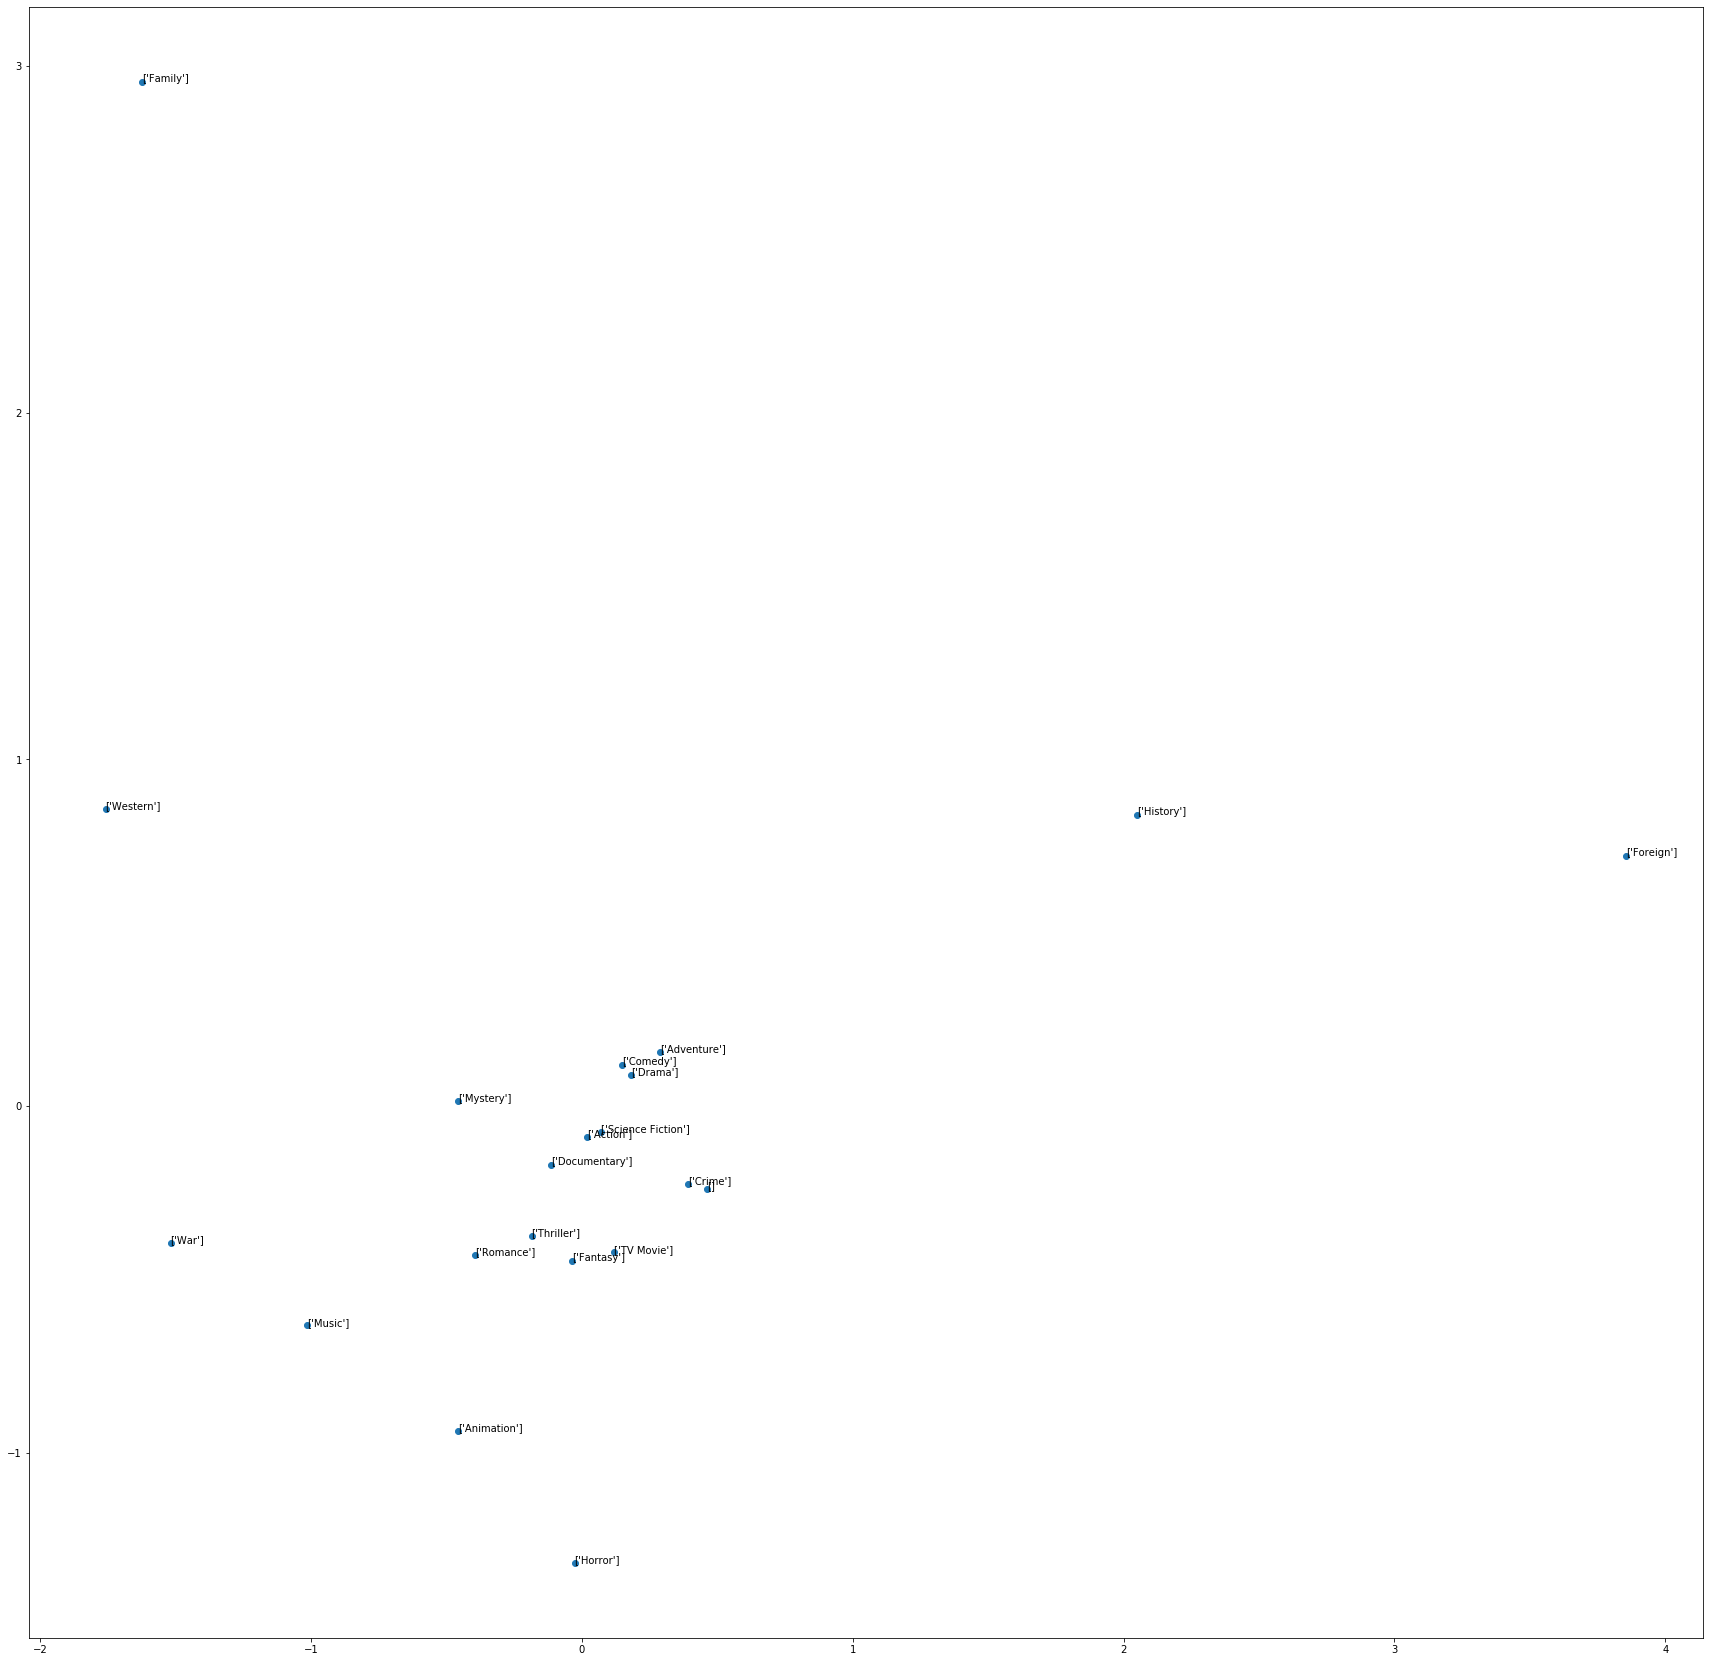

In [409]:
paint_embeddings(model, "genre1")

In [186]:
encoder = model.get_encoder("original_title")
emb = KeyedVectors(encoder.embedding_dim)
emb.add(encoder.labels.astype("str"), encoder.get_weights().cpu().numpy())

In [195]:
df_complete[df_complete['original_title'].str.contains('Dark Knight')]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,crew_size,director,super_soup,userId,movieId,rating,timestamp,top3_genres,userId_copy,movieId_copy
7754372,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",12,155,1.0,943912539,['Drama']['Action']['Crime'],12,155
7754373,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",346,155,4.0,938678947,['Drama']['Action']['Crime'],346,155
7754374,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",792,155,2.0,832241658,['Drama']['Action']['Crime'],792,155
7754375,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",845,155,5.0,830830770,['Drama']['Action']['Crime'],845,155
7754376,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",1460,155,3.0,952730401,['Drama']['Action']['Crime'],1460,155
7754377,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",1608,155,3.0,945200542,['Drama']['Action']['Crime'],1608,155
7754378,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",1918,155,1.0,988567110,['Drama']['Action']['Crime'],1918,155
7754379,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",2035,155,3.0,849033642,['Drama']['Action']['Crime'],2035,155
7754380,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,81,['christophernolan'],"['dccomic', 'crimefight', 'secretident', 'scar...",2381,155,3.0,866384439,['Drama']['Action']['Crime'],2381,155
7754381,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stake

In [197]:
def super_recommender(title=None, user=None, n=10):
    df_aux = pd.DataFrame(columns=['Title', 'Similarity'])
    
    r = emb.most_similar(title, topn=indices.shape[0])
    
    for w, s in r:
        my_dict = {'Title':w, 'Similarity': s}
        df_aux.loc[len(df_aux)] = my_dict
    
    df_aux = df_aux.iloc[0:n]
    
    # make prediction
    if user is not None:
        df_gb = smd.groupby(['original_title']).head(1)[['original_title', 'vote_count', 'vote_average', 'wr', 'year', 'cast', 'director', 'keywords', 'genre1', 'popularity']]
        
        # preparing data
        df_to_predict = df_gb.loc[df_gb['original_title'].isin(df_aux['Title'])]
        df_to_predict['keywords'] = df_to_predict['keywords'].astype('str')
        df_to_predict['director'] = df_to_predict['director'].astype('str')
        df_to_predict['genre1'] = df_to_predict['genre1'].astype('str')
        df_to_predict['cast'] = df_to_predict['cast'].astype('str')
        df_to_predict['userId'] = user
        df_to_predict['rating'] = 0
        
        ml.utils.common_categories(df_complete, df_to_predict)
        
        dataset_test = ml.data.TypedDataset(df_to_predict, metadata)
        y_hat = model.predict(dataset_test[:])[0]

        df_aux['Prediction'] = y_hat.detach().numpy().ravel()
        df_aux = df_aux.sort_values(by=['Prediction'], ascending=False)
    
    return df_aux

In [27]:
super_recommender(title='The Dark Knight', user=500)

,Prediction,Similarity,Title
0,3.986501,0.917741,The Dark Knight Rises
1,3.878561,0.874531,Batman Begins
2,3.832155,0.856432,X-Men
3,3.749050,0.813576,Wonder Woman
4,3.728450,0.790567,Superman
5,3.681782,0.781789,Suicide Squad
6,3.656912,0.789123,Man of Steel
7,3.619012,0.768124,X2
8,3.590907,0.988912,Batman
9,3.234189,0.986712,"Batman: The Dark Knight Returns, Part2"


In [309]:
# End